# Demo polars capabilities and interactively develop it

In [21]:

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import polars as pl
import seaborn as sns

from floris import tools as wfct
from floris.utilities import wrap_360


from flasc.energy_ratio import energy_ratio_suite
from flasc.energy_ratio_polars import energy_ratio_polars as erp

from flasc.visualization import plot_layout_with_waking_directions, plot_binned_mean_and_ci




### Use FLORIS to generate a wake steering data set

<Axes: xlabel='x coordinate (m)', ylabel='y coordinate (m)'>

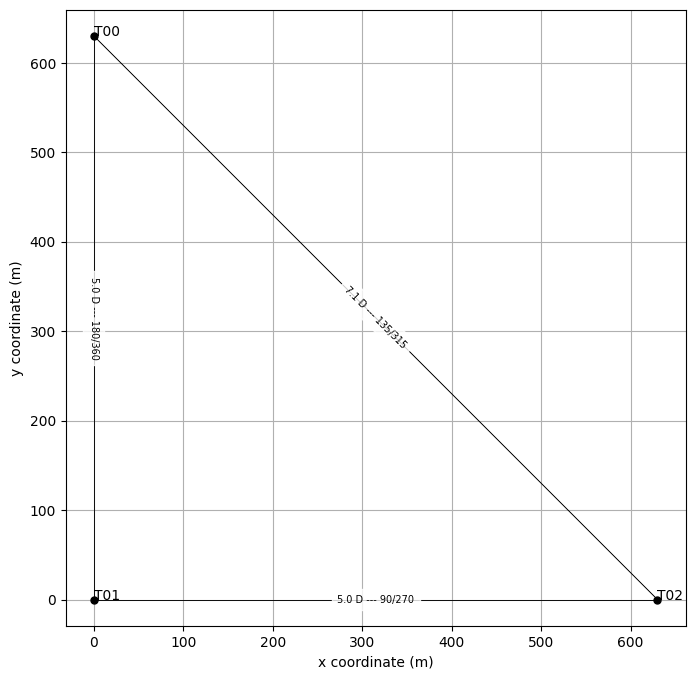

In [24]:


file_path = Path.cwd()
fi_path = file_path / "../../examples_artificial_data/demo_dataset/demo_floris_input.yaml"
fi = wfct.floris_interface.FlorisInterface(fi_path)
fi.reinitialize(layout_x = [0, 0, 5*126], layout_y = [5*126, 0, 0])

# # Show the wind farm
plot_layout_with_waking_directions(fi)



Num Points 16000


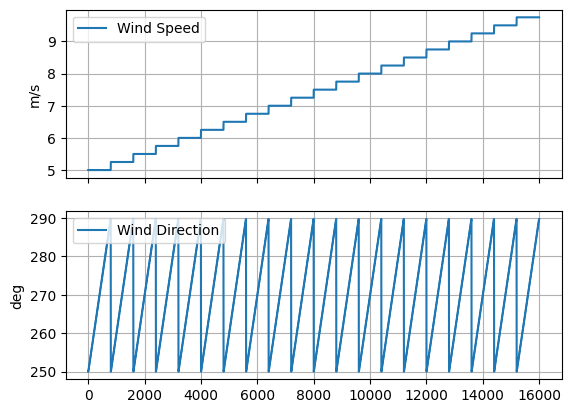

In [25]:
# Create a time history of points where the wind speed and wind direction step different combinations
ws_points = np.arange(5.0,10.0,0.25)
wd_points = np.arange(250.0, 290.0, 0.25,)
num_points_per_combination = 5 # 5 # How many "seconds" per combination

# I know this is dumb but will come back, can't quite work out the numpy version
ws_array = []
wd_array = []
for ws in ws_points:
    for wd in wd_points:
        for i in range(num_points_per_combination):
            ws_array.append(ws)
            wd_array.append(wd)
t = np.arange(len(ws_array))

print(f'Num Points {len(t)}')

fig, axarr = plt.subplots(2,1,sharex=True)
axarr[0].plot(t, ws_array,label='Wind Speed')
axarr[0].set_ylabel('m/s')
axarr[0].legend()
axarr[0].grid(True)
axarr[1].plot(t, wd_array,label='Wind Direction')
axarr[1].set_ylabel('deg')
axarr[1].legend()
axarr[1].grid(True)

In [26]:
# Compute the power of the second turbine for two cases
# Baseline: The front turbine is aligned to the wind
# WakeSteering: The front turbine is yawed 25 deg
fi.reinitialize(wind_speeds=ws_array, wind_directions=wd_array, time_series=True)
fi.calculate_wake()
power_baseline_ref = fi.get_turbine_powers().squeeze()[:,0].flatten() / 1000.
power_baseline_control = fi.get_turbine_powers().squeeze()[:,1].flatten() / 1000.
power_baseline_downstream = fi.get_turbine_powers().squeeze()[:,2].flatten() / 1000.

yaw_angles = np.zeros([len(t),1,3]) * 25
yaw_angles[:,:,1] = 25 # Set control turbine yaw angles to 25 deg
fi.calculate_wake(yaw_angles=yaw_angles)
power_wakesteering_ref = fi.get_turbine_powers().squeeze()[:,0].flatten() / 1000.
power_wakesteering_control = fi.get_turbine_powers().squeeze()[:,1].flatten() /1000.
power_wakesteering_downstream = fi.get_turbine_powers().squeeze()[:,2].flatten() /1000.

## Pandas version (for time)

In [27]:
# Build up the data frames needed for energy ratio suite
df_baseline_pd = pd.DataFrame({
    'wd':wd_array,
    'ws':ws_array,
    'pow_ref':power_baseline_ref,
    'pow_000':power_baseline_ref, 
    'pow_001':power_baseline_control,
    'pow_002':power_baseline_downstream
})

df_wakesteering_pd = pd.DataFrame({
    'wd':wd_array,
    'ws':ws_array,
    'pow_ref':power_wakesteering_ref,
    'pow_000':power_wakesteering_ref, 
    'pow_001':power_wakesteering_control,
    'pow_002':power_wakesteering_downstream
})

# Create alternative versions of each of the above dataframes where the wd/ws are perturbed by noise
df_baseline_noisy_pd = pd.DataFrame({
    'wd':wd_array + np.random.randn(len(wd_array))*5,
    'ws':ws_array + np.random.randn(len(ws_array)),
    'pow_ref':power_baseline_ref,
    'pow_000':power_baseline_ref, 
    'pow_001':power_baseline_control,
    'pow_002':power_baseline_downstream
})

df_wakesteering_noisy_pd = pd.DataFrame({
    'wd':wd_array + np.random.randn(len(wd_array))*5,
    'ws':ws_array + np.random.randn(len(ws_array)),
    'pow_ref':power_wakesteering_ref,
    'pow_000':power_wakesteering_ref, 
    'pow_001':power_wakesteering_control,
    'pow_002':power_wakesteering_downstream
})

color_palette = sns.color_palette("Paired",4)[::-1]

In [28]:
# Initialize the energy ratio suite object and add each dataframe
# separately. 
fsc = energy_ratio_suite.energy_ratio_suite()
# fsc.add_df(df_baseline_pd, 'Baseline', color_palette[0])
# fsc.add_df(df_wakesteering_pd, 'WakeSteering', color_palette[1])
fsc.add_df(df_baseline_noisy_pd, 'Baseline (Noisy)', color_palette[2])
fsc.add_df(df_wakesteering_noisy_pd, 'WakeSteering (Noisy)', color_palette[3])

In [29]:


# Print out the energy ratio
# fsc.print_dfs()


# Calculate and plot the energy ratio for the downstream turbine [2]
# With respect to reference turbine [0]
# datasets with uncertainty quantification using 50 bootstrap samples
fsc.get_energy_ratios(
    test_turbines=[2],
    wd_step=2.0,
    ws_step=1.0,
    N=50,
    percentiles=[5., 95.],
    verbose=False,
    num_blocks=10
)
print('done')
# fsc.plot_energy_ratios(superimpose=True)

fsc.get_energy_ratios_gain(
    test_turbines=[2],
    wd_step=2.0,
    ws_step=1.0,
    N=50,
    percentiles=[5., 95.],
    verbose=False,
    num_blocks=10
)

Dataframes differ in wd and ws. Rebalancing.


/Users/pfleming/opt/anaconda3/envs/floris/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/Users/pfleming/opt/anaconda3/envs/floris/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/Users/pfleming/opt/anaconda3/envs/floris/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,


done
Dataframes differ in wd and ws. Rebalancing.


[{'name': 'WakeSteering (Noisy)/Baseline (Noisy)',
  'color': (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
  'er_results':     baseline  baseline_lb  baseline_ub  wd_bin  bin_count
  0   1.010193     1.010193     1.010193   237.0          3
  1   0.996434     0.986927     0.997715   239.0         15
  2   0.998403     0.990164     1.000500   241.0         28
  3   0.987830     0.975375     0.995638   243.0         47
  4   0.983967     0.981992     0.988363   245.0        132
  5   0.978160     0.967553     0.987261   247.0        226
  6   0.982991     0.975926     0.989580   249.0        318
  7   0.973721     0.958617     0.983174   251.0        443
  8   0.952290     0.941938     0.966770   253.0        602
  9   0.943246     0.908787     0.959492   255.0        651
  10  0.935011     0.916795     0.948619   257.0        715
  11  0.922744     0.906190     0.939320   259.0        733
  12  0.898925     0.874141     0.927990   261.0        771
  13  0.973733     0

# Polars implementation

In [30]:
# Build the dataframes
    # Build up the data frames needed for energy ratio suite
df_baseline = pl.DataFrame({
    'wd_000':wd_array,
    'ws_000':ws_array,
    # 'pow_ref':power_baseline_ref,
    'pow_000':power_baseline_ref, 
    'pow_001':power_baseline_control,
    'pow_002':power_baseline_downstream
})

df_wakesteering = pl.DataFrame({
    'wd_000':wd_array,
    'ws_000':ws_array,
    # 'pow_ref':power_wakesteering_ref,
    'pow_000':power_wakesteering_ref, 
    'pow_001':power_wakesteering_control,
    'pow_002':power_wakesteering_downstream
})

# Create alternative versions of each of the above dataframes where the wd/ws are perturbed by noise
df_baseline_noisy = pl.DataFrame({
    'wd_000':wd_array + np.random.randn(len(wd_array))*5,
    'ws_000':ws_array + np.random.randn(len(ws_array)),
    # 'pow_ref':power_baseline_ref,
    'pow_000':power_baseline_ref, 
    'pow_001':power_baseline_control,
    'pow_002':power_baseline_downstream
})

df_wakesteering_noisy = pl.DataFrame({
    'wd_000':wd_array + np.random.randn(len(wd_array))*5,
    'ws_000':ws_array + np.random.randn(len(ws_array)),
    # 'pow_ref':power_wakesteering_ref,
    'pow_000':power_wakesteering_ref, 
    'pow_001':power_wakesteering_control,
    'pow_002':power_wakesteering_downstream
})

In [31]:


df_energy = erp.get_energy_table([df_baseline_noisy, df_wakesteering_noisy], ['baseline', 'wakesteering'])
df_energy

wd_000,ws_000,pow_000,pow_001,pow_002,df_name,block
f64,f64,f64,f64,f64,str,i64
260.224411,3.697807,383.695142,383.695142,383.449692,"""baseline""",0
250.367106,5.384596,383.695142,383.695142,383.449692,"""baseline""",0
256.829895,4.675461,383.695142,383.695142,383.449692,"""baseline""",0
239.821181,4.655318,383.695142,383.695142,383.449692,"""baseline""",0
253.728915,5.547945,383.695142,383.695142,383.449692,"""baseline""",0
257.448023,4.201696,383.695142,383.695142,383.397784,"""baseline""",0
253.333653,5.100074,383.695142,383.695142,383.397784,"""baseline""",0
253.495177,3.381332,383.695142,383.695142,383.397784,"""baseline""",0
249.312217,4.957696,383.695142,383.695142,383.397784,"""baseline""",0


In [32]:
# erp.compute_energy_ratio(df_energy, [0], [2], df_names=['Baseline', 'WakeSteering'])

df_erb = erp.compute_energy_ratio_bootstrap(df_energy, [0], [2], df_names=['baseline', 'wakesteering'], N=50)

## Compare the energy ratio plots

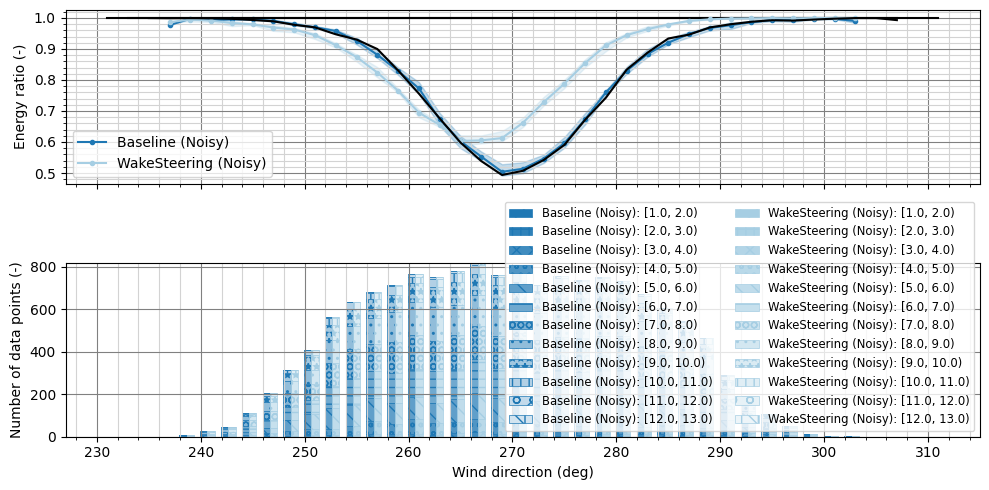

In [33]:
axarr = fsc.plot_energy_ratios(superimpose=True)

ax = axarr[0]
ax.plot(df_erb['wd_bin'], df_erb['baseline'], color='k')

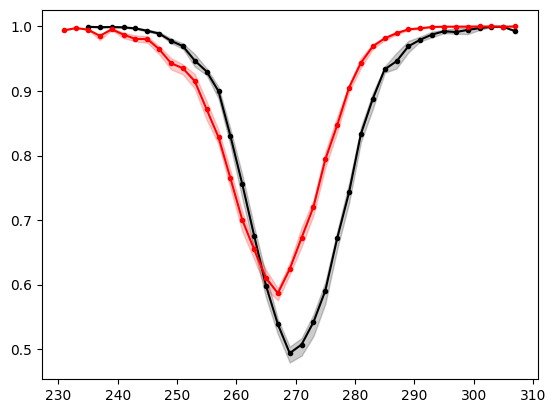

In [34]:
fig ,ax = plt.subplots()

ax.plot(df_erb['wd_bin'], df_erb['baseline'],'.-', color='k')
ax.fill_between(df_erb['wd_bin'], df_erb['baseline_lb'], df_erb['baseline_ub'], color='k', alpha=0.2)

ax.plot(df_erb['wd_bin'], df_erb['wakesteering'], '.-', color='r')
ax.fill_between(df_erb['wd_bin'], df_erb['wakesteering_lb'], df_erb['wakesteering_ub'], color='r', alpha=0.2)

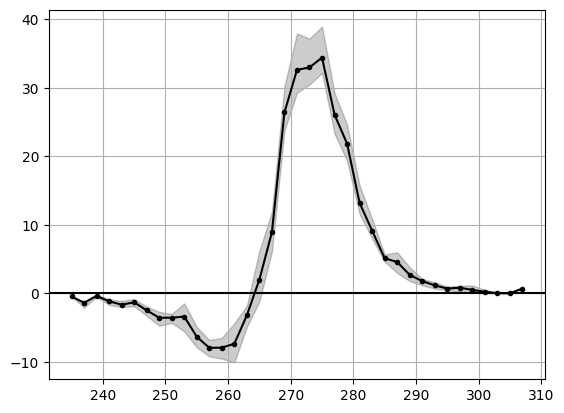

In [35]:
fig ,ax = plt.subplots()

ax.plot(df_erb['wd_bin'], df_erb['uplift'],'.-', color='k')
ax.fill_between(df_erb['wd_bin'], df_erb['uplift_lb'], df_erb['uplift_ub'], color='k', alpha=0.2)
ax.grid(True)
ax.axhline(0, color='k')


## Test out simley approach to calculating energy ratio uplift in regions

In [36]:

erp.compute_uplift_in_region(df_energy, [0], [2], df_names=['baseline', 'wakesteering'])

delta_energy,base_test_energy,uplift
f64,f64,f64
668714.690495,9.8413e6,6.794986


In [37]:

erp.compute_uplift_in_region_bootstrap(df_energy, [0], [2], df_names=['baseline', 'wakesteering'], N=20)

delta_energy_exp,delta_energy_ub,delta_energy_lb,base_test_energy_exp,base_test_energy_ub,base_test_energy_lb,uplift_exp,uplift_ub,uplift_lb
f64,f64,f64,f64,f64,f64,f64,f64,f64
668714.690495,912836.44867,558274.592278,9.8413e6,1.3910e7,7.8101e6,6.794986,7.258943,6.729971
